In [28]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential,Model,model_from_json
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import glob
import keras
from keras.applications import vgg16
from keras.layers import Input
import matplotlib.pyplot as plt

# Data Augmentation

In [35]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('C:\\MyLearnings\\DeepLearning\\Kaggle_Datasets\\Fruit detection\\fruit-images-for-object-detection\\dataset\\train\\',
                                                 target_size = (224, 224),
                                                 batch_size = 8,
                                                 shuffle= True,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('C:\\MyLearnings\\DeepLearning\\Kaggle_Datasets\\Fruit detection\\fruit-images-for-object-detection\\dataset\\test\\',
                                            target_size = (224, 224),
                                            batch_size = 8,
                                            shuffle = True,
                                            class_mode = 'categorical')



Found 220 images belonging to 3 classes.
Found 55 images belonging to 3 classes.


 # Baseline model

In [45]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (224,224,3),activation = 'relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,(3,3),activation = 'relu'))
model.add(MaxPooling2D((2,2)))



model.add(Flatten())
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation = 'softmax'))

adam = keras.optimizers.RMSprop(learning_rate = 1e-5)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 86528)            

In [46]:
history = model.fit_generator(training_set, epochs = 60, validation_data = test_set)

Epoch 1/60
 5/28 [====>.........................] - ETA: 7s - loss: 1.1237 - accuracy: 0.3500

C:\Users\Ramya\anaconda3\envs\tf-gpu\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


28/28 [==============================] - 8s 300ms/step - loss: 1.1040 - accuracy: 0.3273 - val_loss: 1.0237 - val_accuracy: 0.5455
Epoch 2/60
28/28 [==============================] - 8s 284ms/step - loss: 1.0469 - accuracy: 0.4545 - val_loss: 1.0516 - val_accuracy: 0.4000
Epoch 3/60
28/28 [==============================] - 9s 306ms/step - loss: 1.0277 - accuracy: 0.4909 - val_loss: 1.0117 - val_accuracy: 0.7818
Epoch 4/60
28/28 [==============================] - 9s 315ms/step - loss: 0.9891 - accuracy: 0.5636 - val_loss: 0.8983 - val_accuracy: 0.6909
Epoch 5/60
28/28 [==============================] - 9s 305ms/step - loss: 0.9181 - accuracy: 0.6182 - val_loss: 1.0234 - val_accuracy: 0.6364
Epoch 6/60
28/28 [==============================] - 9s 324ms/step - loss: 0.9006 - accuracy: 0.6545 - val_loss: 0.8144 - val_accuracy: 0.8182
Epoch 7/60
28/28 [==============================] - 9s 315ms/step - loss: 0.8563 - accuracy: 0.7091 - val_loss: 0.7952 - val_accuracy: 0.8364
Epoch 8/60
28/28 

 # Plot accuracies

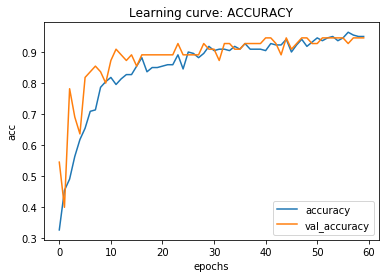

In [47]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.title("Learning curve: ACCURACY")
plt.show()

 # Plot losses

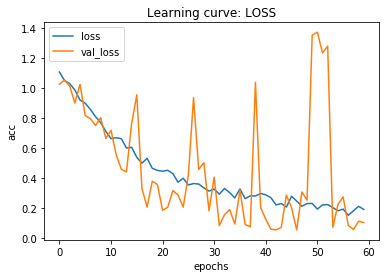

In [48]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.title("Learning curve: LOSS")
plt.show()

# Transfer Learning

In [18]:
input_tensor = Input(shape=(224, 224, 3))
vgg_model = vgg16.VGG16(weights='imagenet',
                               include_top=False,
                               input_tensor=input_tensor)

# Make sure that the pre-trained bottom layers are not trainable
for layer in vgg_model.layers:
    layer.trainable = False
    
# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

# Getting output tensor of the last VGG layer that we want to include
x = layer_dict['block3_pool'].output

# Stacking a new simple convolutional network on top of it    
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)

# Creating new model. Please note that this is NOT a Sequential() model.
from keras.models import Model
custom_model = Model(input=vgg_model.input, output=x)



# Do not forget to compile it
adma_opt= keras.optimizers.RMSprop(learning_rate= 1e-4)
custom_model.compile(loss='categorical_crossentropy',
                     optimizer=adma_opt,
                     metrics=['accuracy'])
print("Model compiled")
custom_model.summary()
model = custom_model

Model compiled
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 

C:\Users\Ramya\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [19]:
history = custom_model.fit_generator(training_set,  epochs = 100, validation_data = test_set)

Epoch 1/100
 4/28 [===>..........................] - ETA: 8s - loss: 73.8018 - accuracy: 0.2500

C:\Users\Ramya\anaconda3\envs\tf-gpu\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


28/28 [==============================] - 11s 408ms/step - loss: 43.5189 - accuracy: 0.4318 - val_loss: 45.0685 - val_accuracy: 0.5818
Epoch 2/100
28/28 [==============================] - 10s 344ms/step - loss: 18.7243 - accuracy: 0.6500 - val_loss: 32.6062 - val_accuracy: 0.5636
Epoch 3/100
28/28 [==============================] - 10s 350ms/step - loss: 20.2314 - accuracy: 0.6227 - val_loss: 63.9812 - val_accuracy: 0.5818
Epoch 4/100
28/28 [==============================] - 10s 346ms/step - loss: 12.6151 - accuracy: 0.7045 - val_loss: 5.0752 - val_accuracy: 0.7091
Epoch 5/100
28/28 [==============================] - 10s 348ms/step - loss: 11.1519 - accuracy: 0.7409 - val_loss: 19.1914 - val_accuracy: 0.5818
Epoch 6/100
28/28 [==============================] - 10s 354ms/step - loss: 13.6634 - accuracy: 0.7136 - val_loss: 3.3296 - val_accuracy: 0.8182
Epoch 7/100
28/28 [==============================] - 10s 355ms/step - loss: 8.9026 - accuracy: 0.7636 - val_loss: 0.0000e+00 - val_accurac

# Plot accuracies

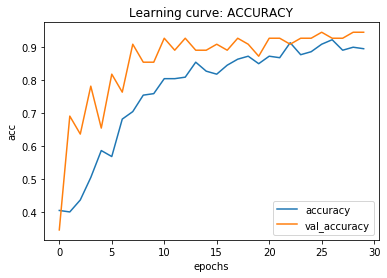

In [38]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.title("Learning curve: ACCURACY")
plt.show()

# Plot losses

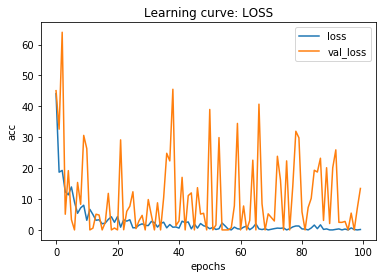

In [21]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.title("Learning curve: LOSS")
plt.show()